In [2]:
# Wyłączenie ostrzerzeń w ramach skrypty
options(warn = -1)

# Zimportowanie bibliotek
library('car')
library('RcmdrMisc')
library('sandwich')
library('relimp')
library('corrplot')



Loading required package: carData

Loading required package: sandwich

corrplot 0.95 loaded



In [4]:
# Zaimportowanie zbiorów Day oraz Hour
Day<-read.csv("http://jolej.linuxpl.info/day.csv", header=TRUE)
Hour<-read.csv("http://jolej.linuxpl.info/hour.csv", header=TRUE)

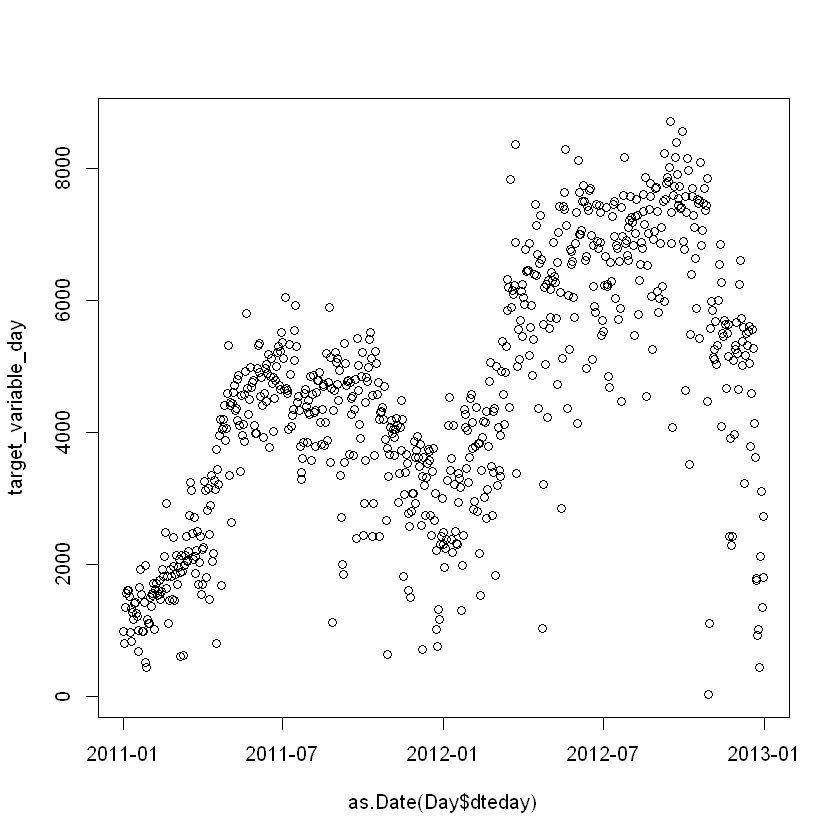

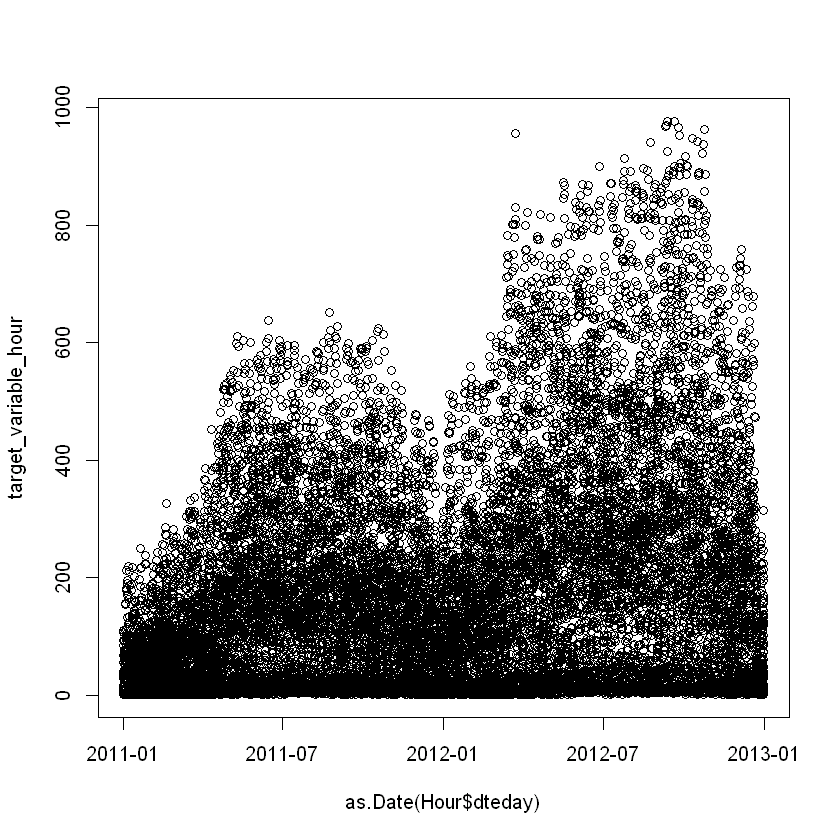

In [6]:
# Wybór zmiennej zależnej
target_variable_day <- Day$cnt
target_variable_day_name <- colnames(Day)[which(sapply(Day, identical, target_variable_day))]
plot(as.Date(Day$dteday), target_variable_day)

target_variable_hour <- Hour$cnt
target_variable_hour_name <- colnames(Hour)[which(sapply(Hour, identical, target_variable_hour))]
plot(as.Date(Hour$dteday), target_variable_hour)

In [8]:
# Po wyświetleniu wykresów zmiennej cnt dla obu zbiorów widać, że Hours posiada znacznie więcej punktów, dużo z nich o bardzo niskich wartościach
# Wynika to z tego, że rejestrując co godzinę rejestruje również godziny nocne, w których liczba wypożyczeń jest praktycznie znikoma
# Dlatego przy dalszej analizie skupię się na zbiorze Day

In [10]:
# Sprawdzenie wszystkich zmiennych
summary(Day)

    instant         dteday              season            yr        
 Min.   :  1.0   Length:731         Min.   :1.000   Min.   :0.0000  
 1st Qu.:183.5   Class :character   1st Qu.:2.000   1st Qu.:0.0000  
 Median :366.0   Mode  :character   Median :3.000   Median :1.0000  
 Mean   :366.0                      Mean   :2.497   Mean   :0.5007  
 3rd Qu.:548.5                      3rd Qu.:3.000   3rd Qu.:1.0000  
 Max.   :731.0                      Max.   :4.000   Max.   :1.0000  
      mnth          holiday           weekday        workingday   
 Min.   : 1.00   Min.   :0.00000   Min.   :0.000   Min.   :0.000  
 1st Qu.: 4.00   1st Qu.:0.00000   1st Qu.:1.000   1st Qu.:0.000  
 Median : 7.00   Median :0.00000   Median :3.000   Median :1.000  
 Mean   : 6.52   Mean   :0.02873   Mean   :2.997   Mean   :0.684  
 3rd Qu.:10.00   3rd Qu.:0.00000   3rd Qu.:5.000   3rd Qu.:1.000  
 Max.   :12.00   Max.   :1.00000   Max.   :6.000   Max.   :1.000  
   weathersit         temp             atemp    

In [12]:
# Po analize podsumowania stwierdzam, ze zmienne nie posiadaja wartosci null
# odchylenia standardowe są bardzo małe, żadna z nich nie wskazuje na to, żeby miała mieć dużą istotność

In [14]:
# Określenie wartości logicznej dla każdej kolumny czy jest numeryczna (prawda jeśli tak, fałsz jeśli nie)
numeric_vars <- sapply(Day, is.numeric)
# Wybranie na podstawie numeric_vars samych kolumn o wartościach numerycnzych
numeric_vars_names <- names(
  numeric_vars[
    numeric_vars == TRUE 
    & names(numeric_vars) != target_variable_day_name
    & names(numeric_vars) != "casual"
    & names(numeric_vars) != "registered"])
# Stworzenie formuły do listowania zmiennych numerycznych dla wykresu
numeric_vars_formula <- as.formula(paste("~", paste(numeric_vars_names, collapse = "+")))

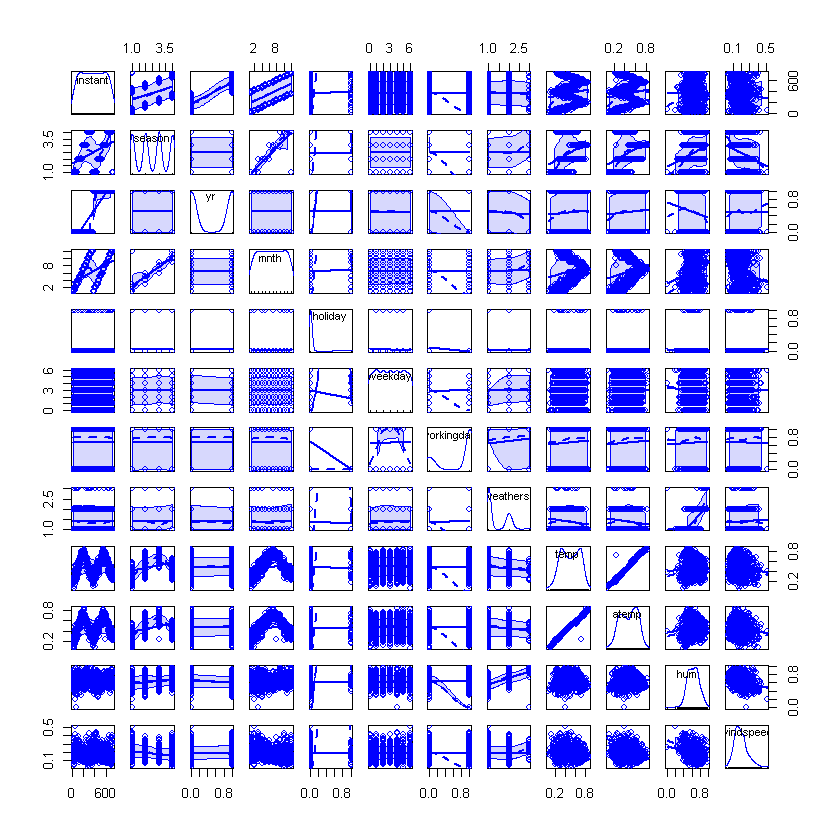

In [16]:
# Wykres macierzowy
# numeric_vars_day_formula - lista zmiennych do analizy
# reg.line=lm - dodanie linii regresji liniowej
# smooth=TRUE - dodanie wygładzonej linii regresji na wykresach rozrzutu
# spread=FALSE - wyłączenie rysowania wykresu odchylenia standardowego wokół linii regresji
# span=0.5 - wykorzystanie 50% danych lokalnych do obliczenia krzywej wygładzenia
# id.n=0 - wyłączenie etykietowania abserwacji odstających
# diagonal='boxplot' - rodzaj wizualizacji na przekątnych w postaci wykresu pudełkowego
# data=Day - dane wejściowe do wykresu
scatterplotMatrix(numeric_vars_formula,
                  reg.line=lm, smooth=TRUE, spread=FALSE, span=0.5, id.n=0, 
                  diagonal = 'boxplot', data=Day)

In [18]:
# Wykresy pokazują, że rozkład zmiennych jest bardzo zróżnicowany
# Widać po nich również jak zmieniają się warunki w zależności od czasu:
# - season - zdarza się cyklicznie
# - holiday - wakacje są raz w roku
# - temp/atemp - temperatura zmienia się w zależności od pory roku
# - windspeed - duży w jednej porze roku, w inne mniejszy

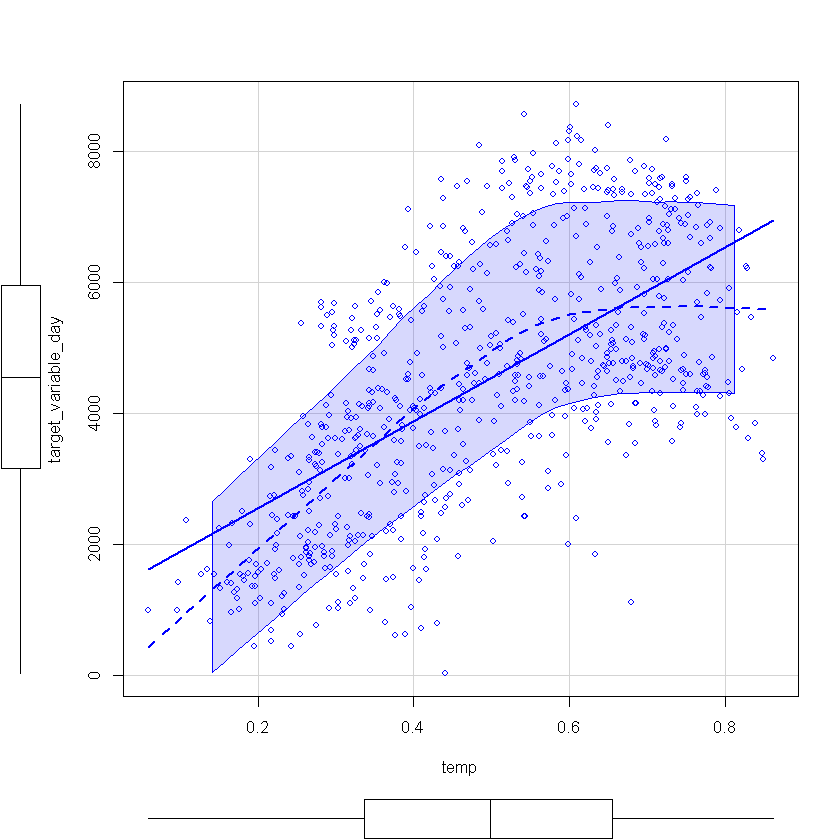

In [20]:
# wykres punktowy
# target_variable_day~temp - określa zmienne do wykresu
# reg.line=lm - dodanie linii regresji liniowej
# smooth=TRUE - dodanie wygładzonej linii regresji na wykresach rozrzutu
# spread=FALSE - wyłączenie rysowania wykresu odchylenia standardowego wokół linii regresji
# id.method='mahal' - użycie odległości Mahalanobisa do wykrycia obserwacji i etykierowania obserwacji odstających
# id.n = 2 - określenie liczby obserwacji odstających do etykierowania
# boxplots='xy' - rysuje wykresy pudełkowe wzdłuż osi x i y
# span=0.5 - szerokość okna dla krzywej wygłaszenia
# data=Day - dane wejściowe do wykresu
scatterplot(target_variable_day~temp, reg.line=lm, smooth=TRUE, spread=FALSE, id.method='mahal', id.n = 2, boxplots='xy', span=0.5, data=Day)

In [22]:
# Wraz ze wzrostem temperatury rośnie liczba wypożyczeń, stabilizuje się po pewnej wartości
# rośnie również niepewność względem dalszych przewidywań (inaczej szansa, że regresja będzie zgodna z danymi)

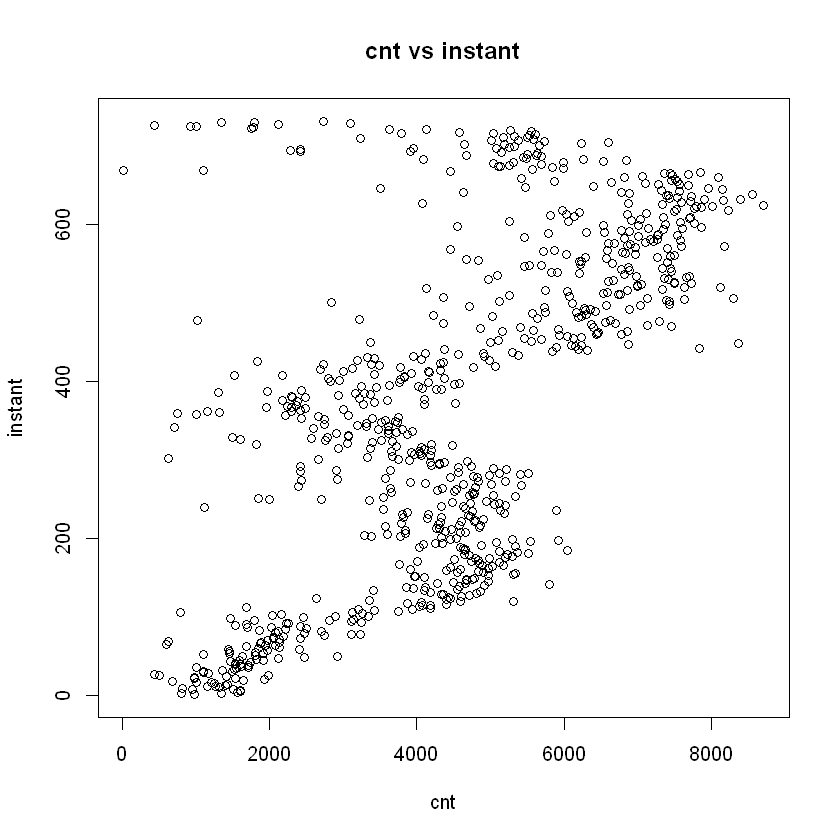

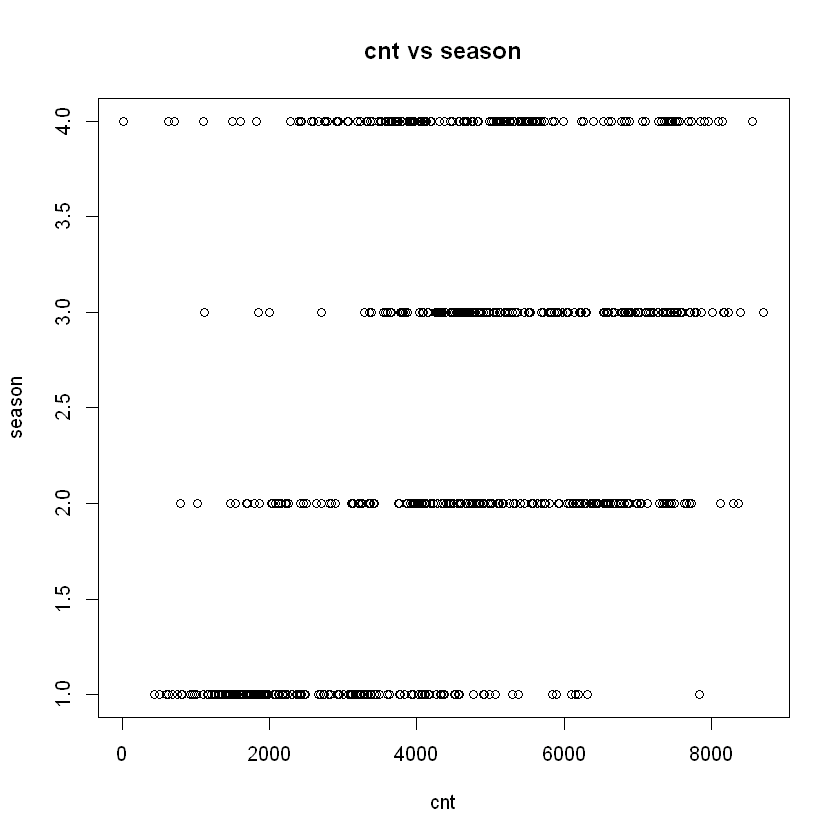

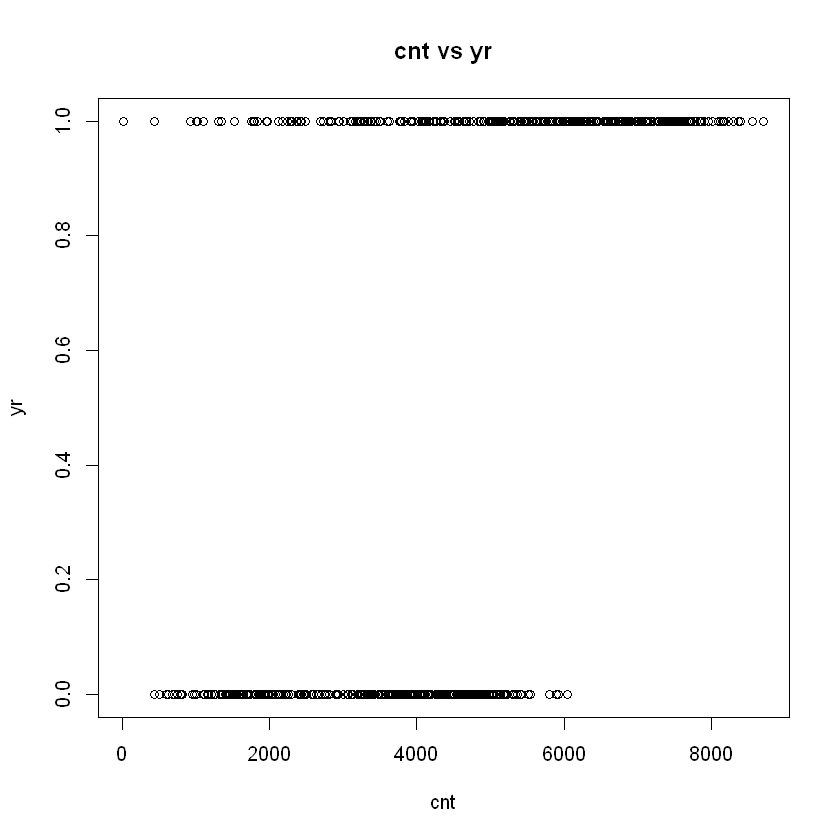

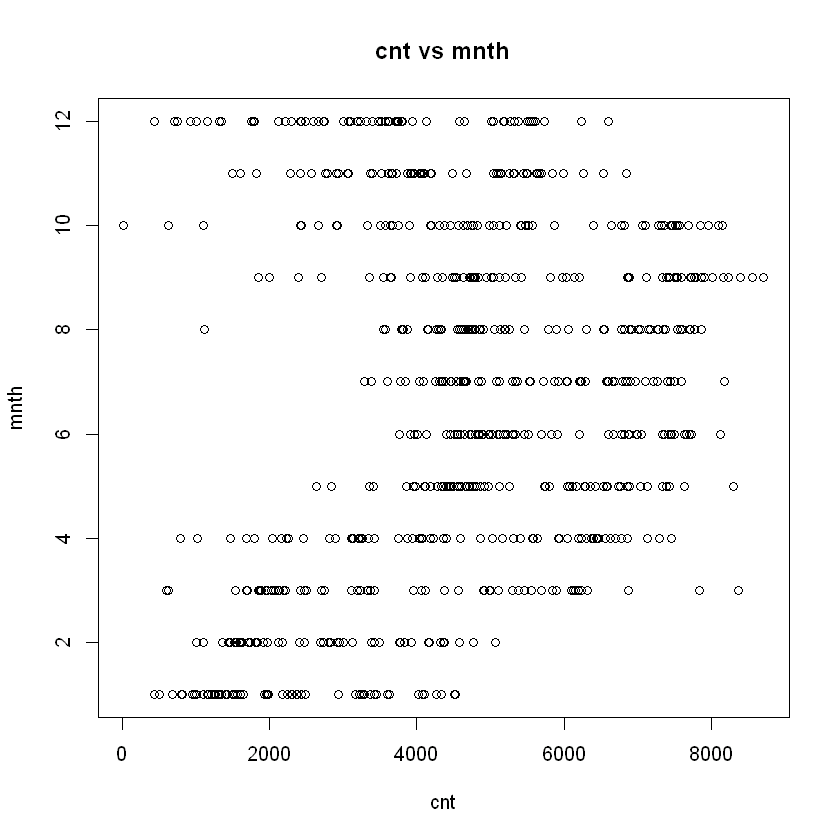

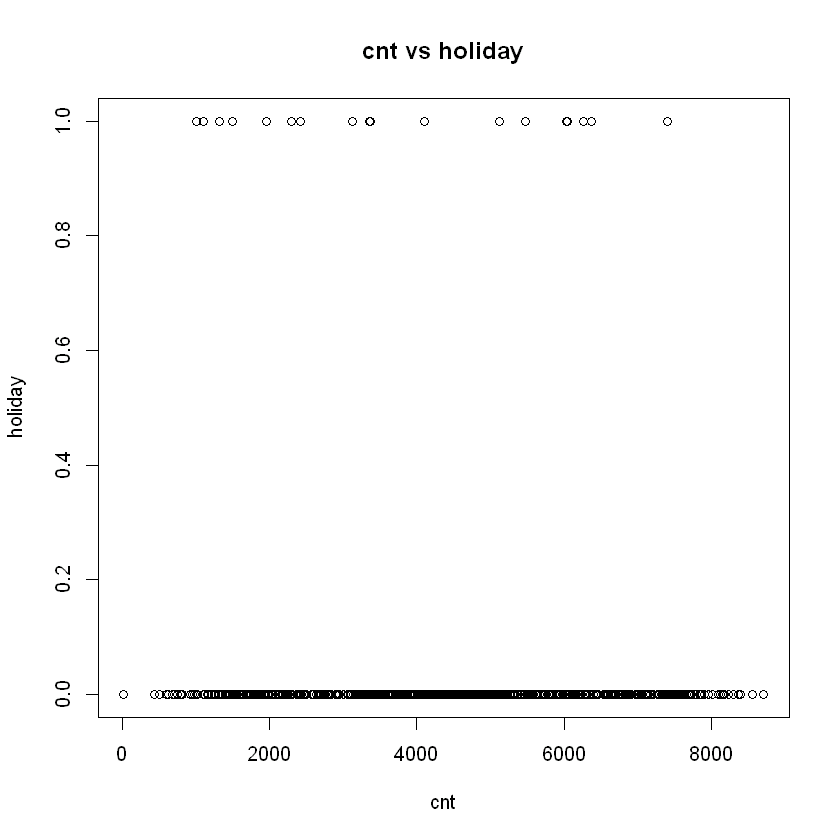

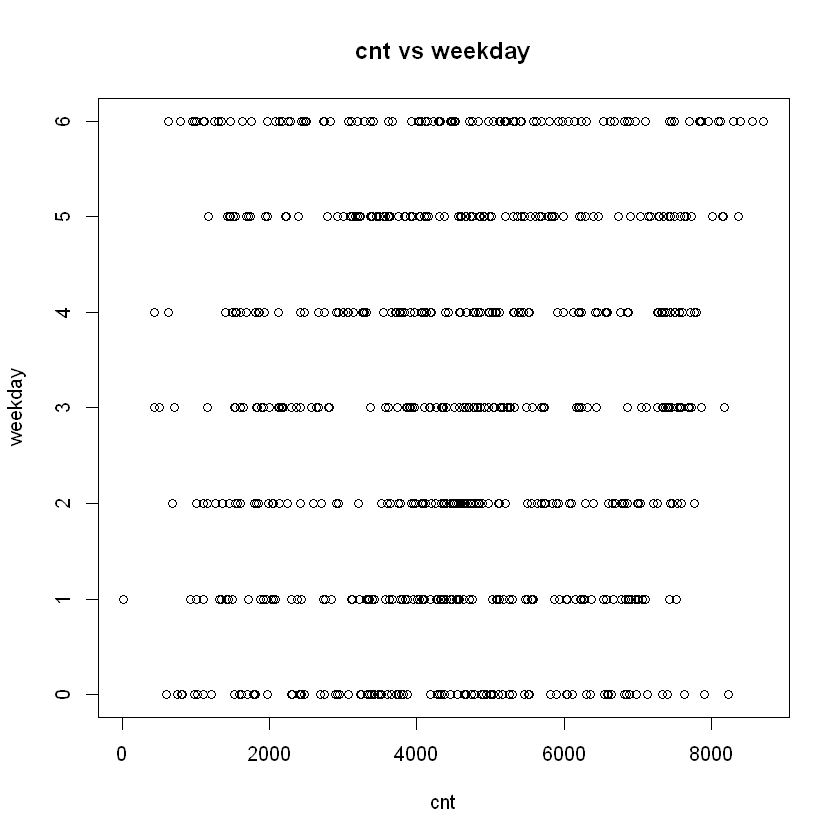

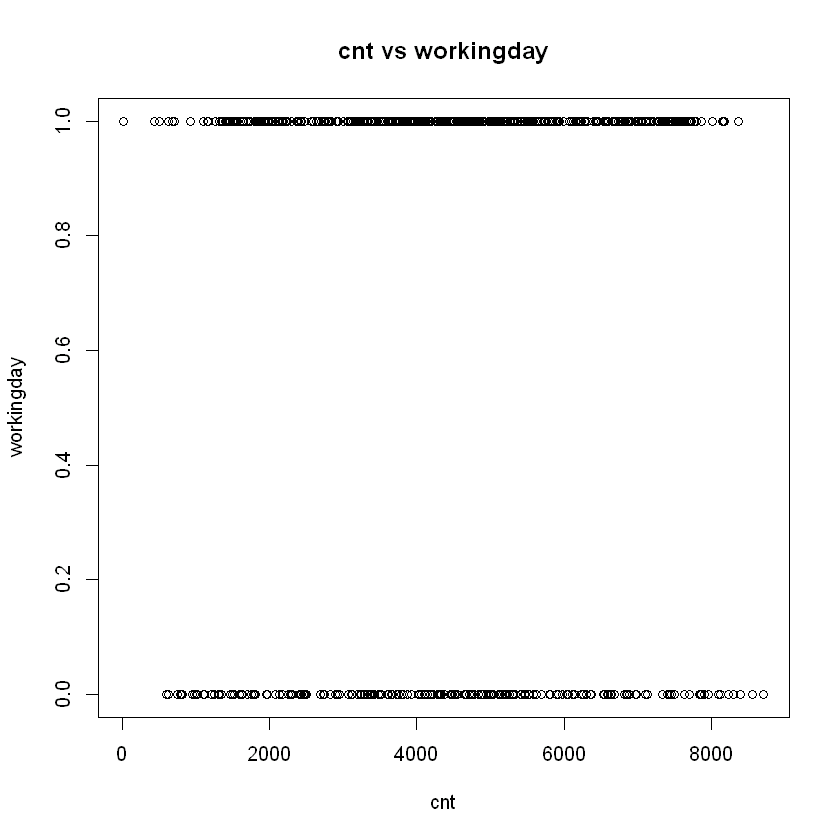

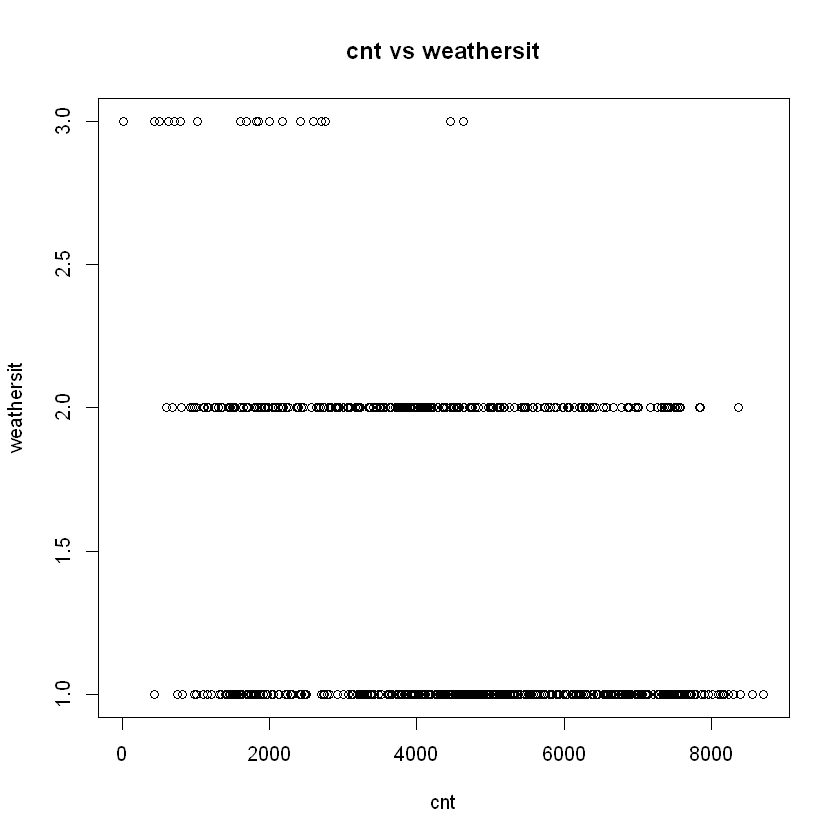

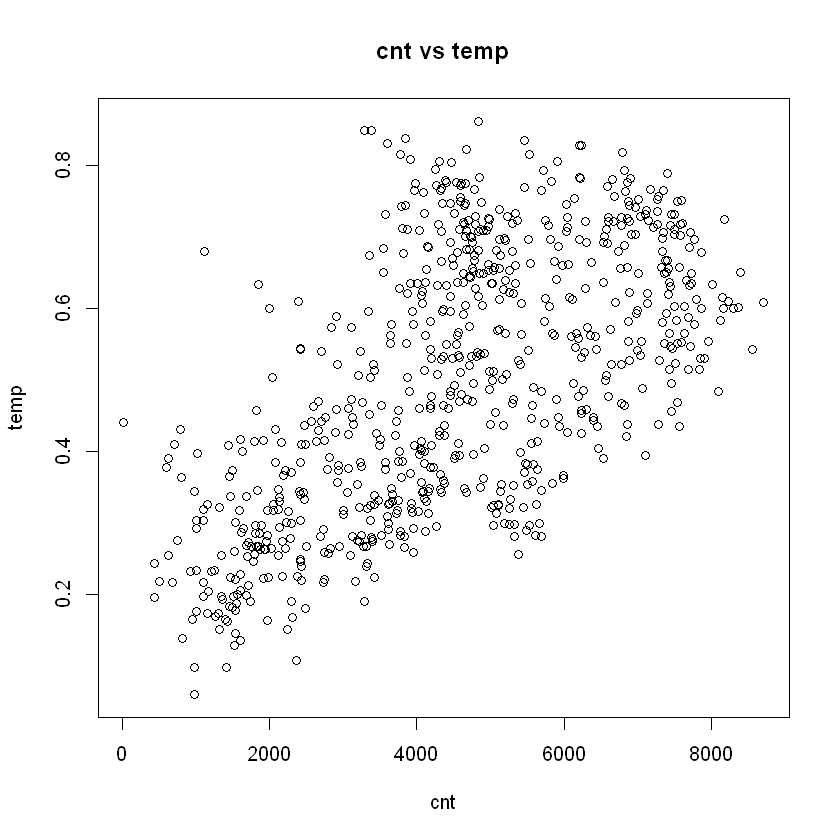

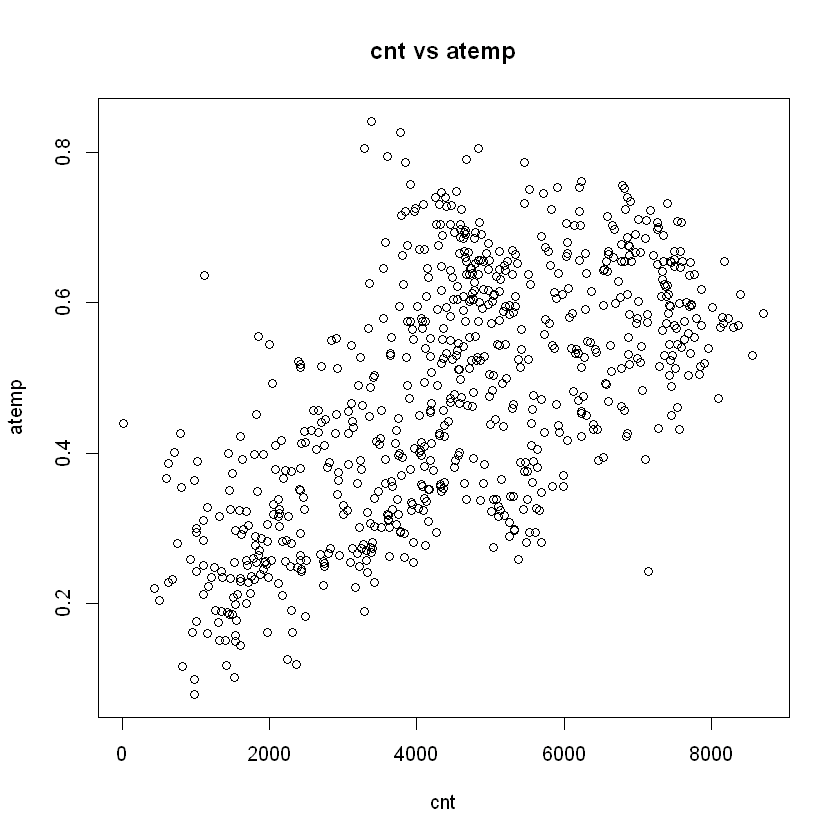

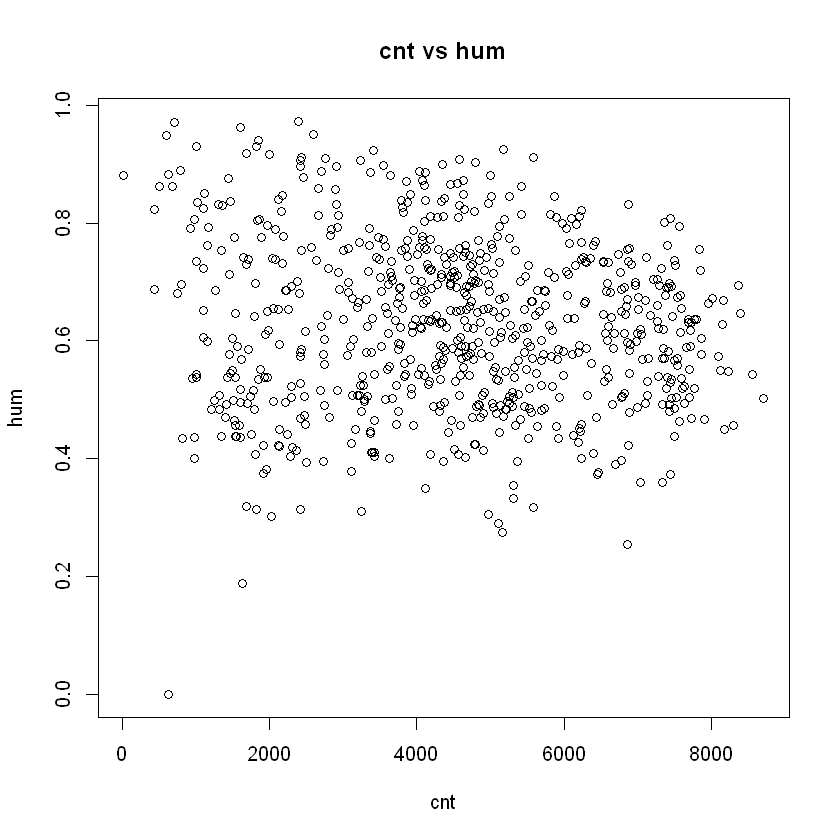

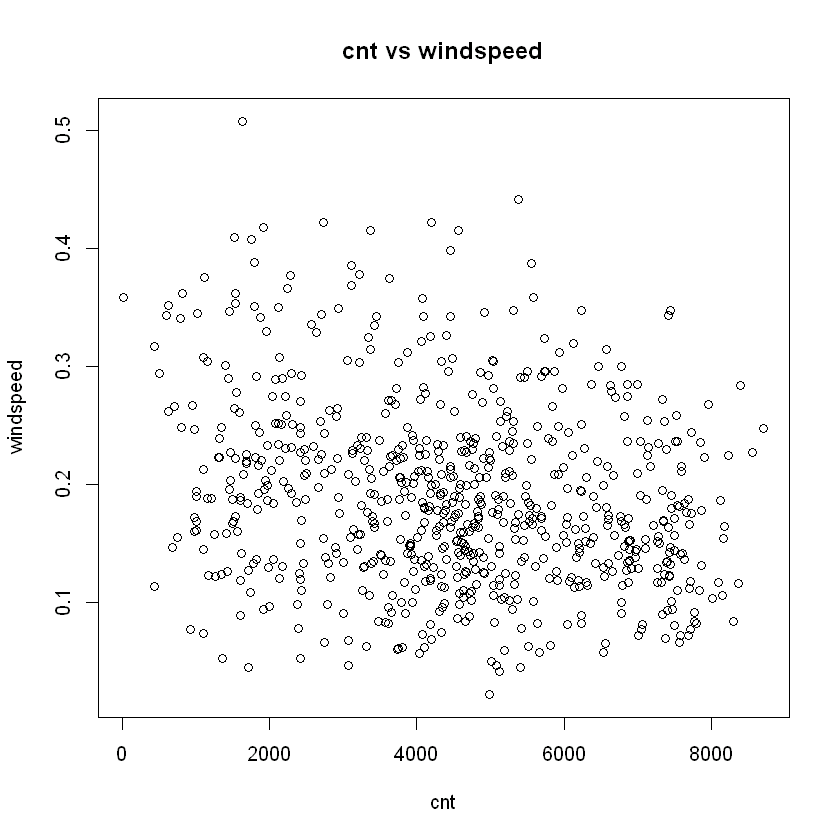

In [24]:
# Zbudowa? wykresy dla kombinacji zmiennej zależnej i posta?ych zmiennych nie czynnikowych
# Pętla po wszystkich koumnach numerycznych
for (var in numeric_vars_names) {
  # Tworzenie wykresu rozrzutu
  # Day[[target_variable_day_name]] - zmienne dla osi x
  # Day[[var]] - iterowana zmienna
  # main = paste(target_variable_day_name, "vs", var) - tytuł wykresu
  # xlab = target_variable_day_name - etykieta osi x
  # ylab = var - etykieta osi y
  plot(Day[[target_variable_day_name]], Day[[var]], main = paste(target_variable_day_name, "vs", var), xlab = target_variable_day_name, ylab = var)
}

In [26]:
# wnioski z analizy wykresów i ocena przewidywanego wpływu na zmienną zależną
# cnt vs czas (season, yr, mnth, holiday, weekday, workingday): pora roku i czy dzień pracujący mają wpływ na liczbę wypożyczeń - duży wpływ
# cnt vs weathersit: rodzaj pogody ma wpływ na liczbę wypożyczeń - duży wpływ
# cnt vs temperatura (temp, atemp): wzrost temperatury powoduje wzrost liczby wypożyczeń - duży wpływ
# cnt vs hum: nieznacznie mniejsze wypżyczenie przy zwiększonej wilkgotności - mały wpływ
# cnt vs windspeed: nieznacznie mniejsze wypżyczenie przy zwiększonym wietrze - mały wpływ

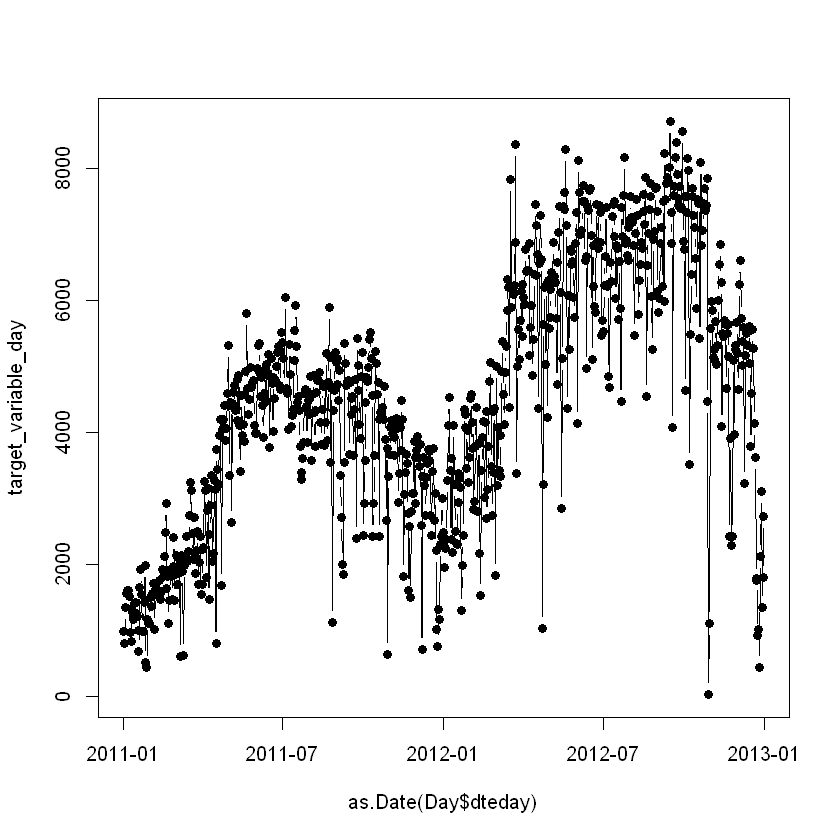

In [28]:
# Wykres liniowy
# with umożliwia odwołąnie się do kolumn ramki bez ich listowania poprzez data$column
with(Day, lineplot(as.Date(Day$dteday), target_variable_day))
# Widać tentencje wzrostowe w miesiące letnie
# Widać jeden duży spadek (majniższy punkt), wynika on z tego, że 2012-10-30 był huragan (Hurricane Sandy)
# Duży pik jest natomiast w marcu, jeden z nich wynika z daty 17 marca, jest to Dzień Świętego Patryka

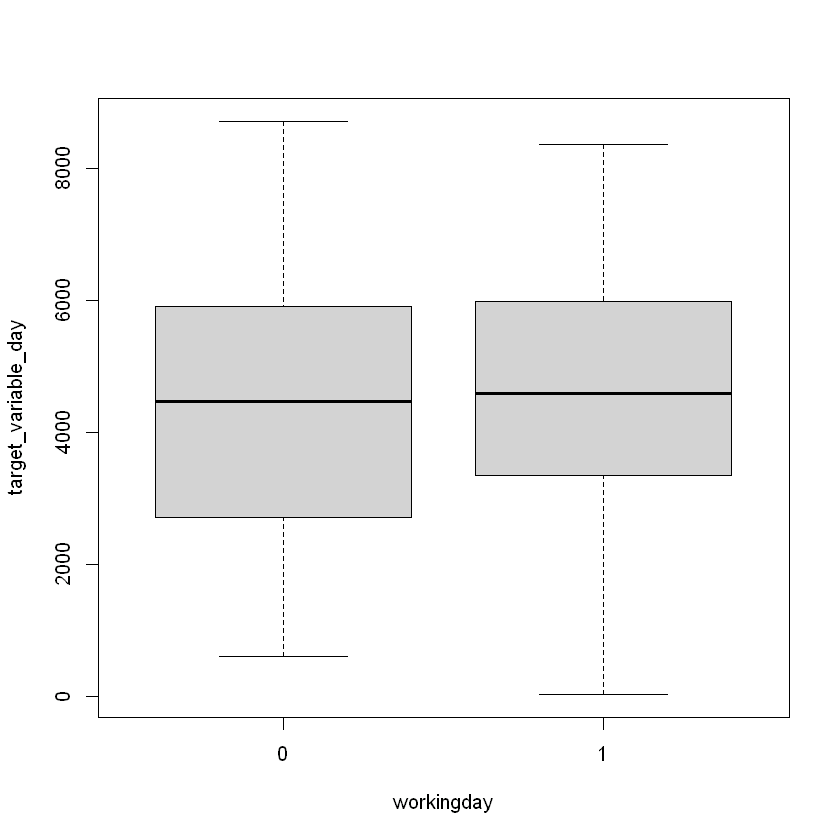

In [30]:
# Wykres pudełkowy dla podzielonego zbioru cnt na kategorie w zależności od tego czy jest to dzień pracujący
Boxplot(target_variable_day~workingday, data=Day)
# Jak widać liczba wypożyczeń nie różni się znacznie w zależności od tego czy jest to dzień pracujący

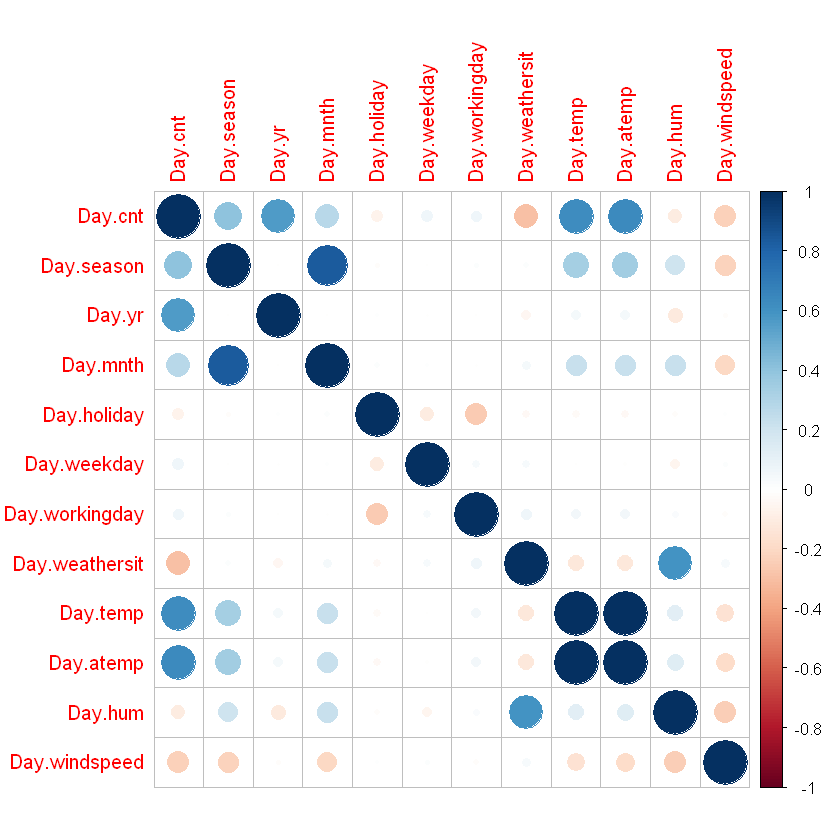

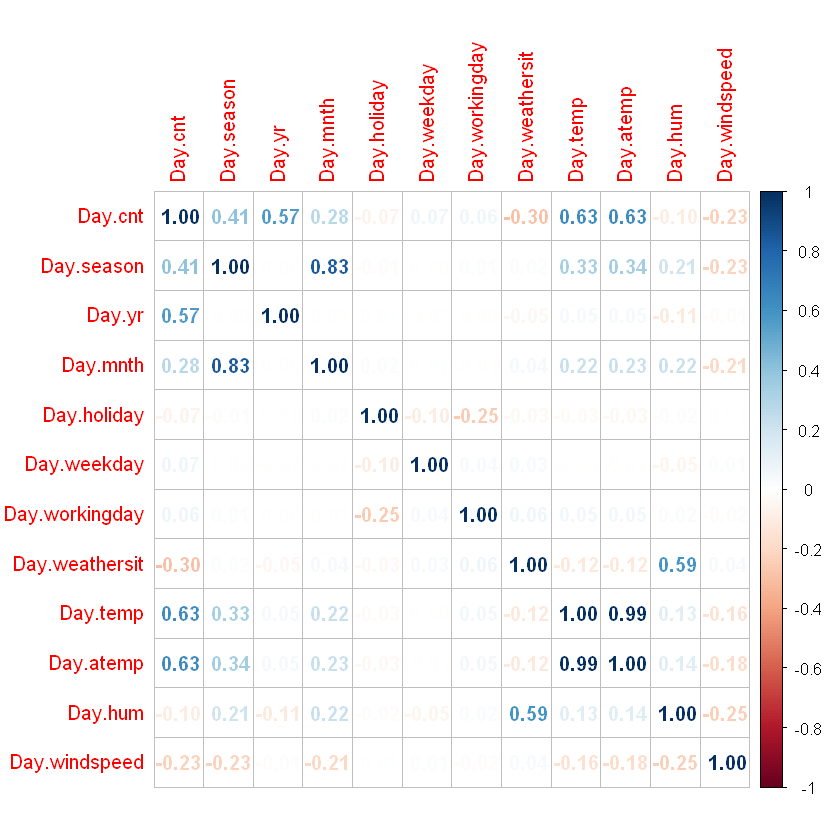

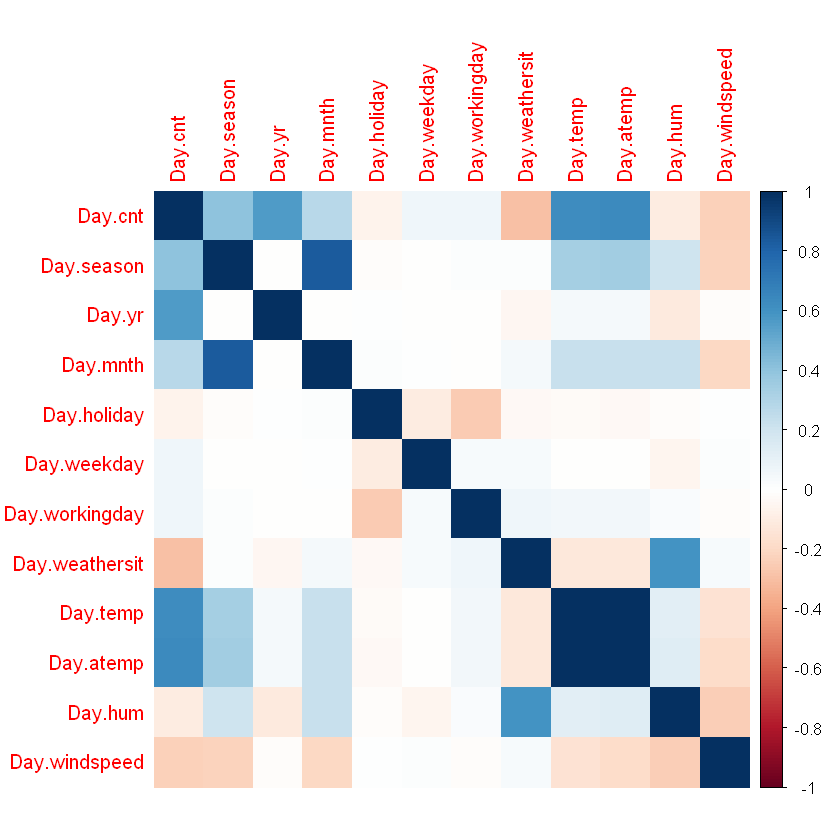

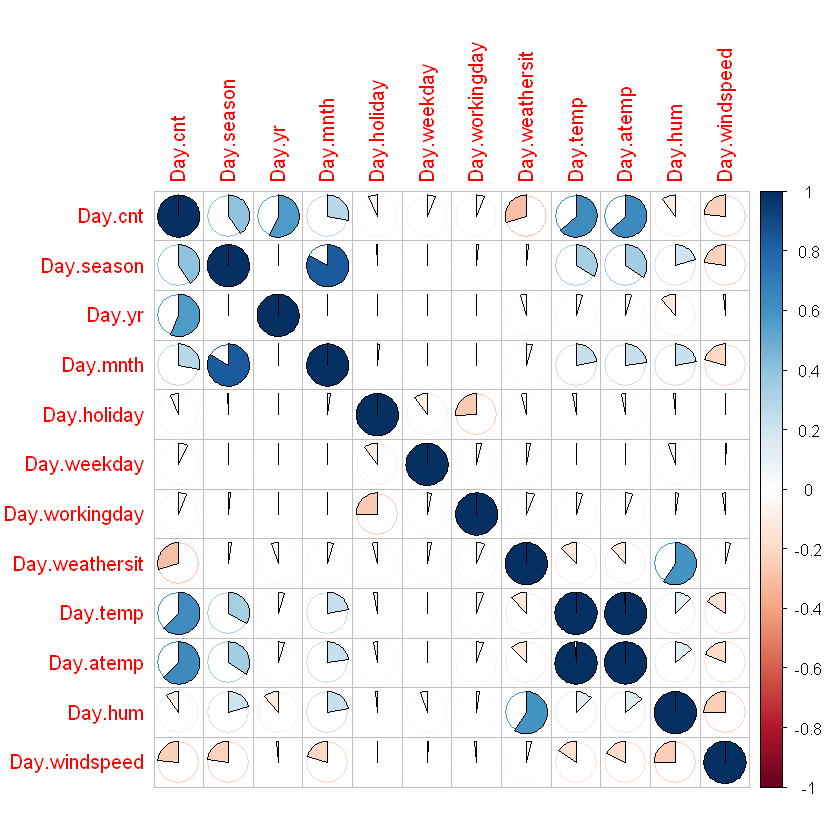

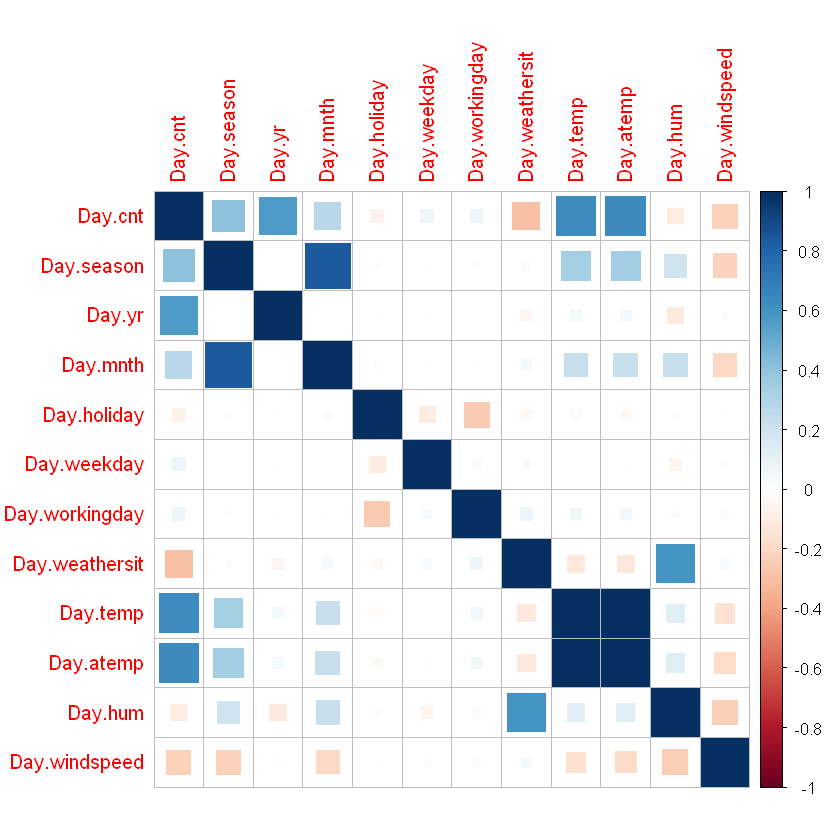

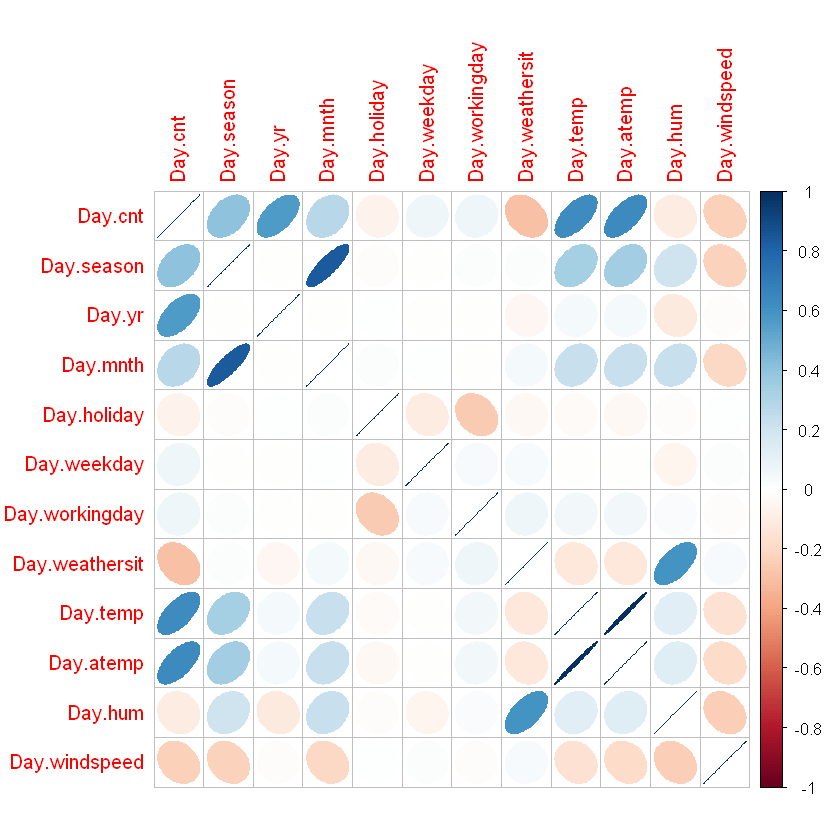

In [32]:
# Analiza korelacji zmiennych
# Pakiet corrplot 

# Tworzenie ramki dla zmiennych numerycznych Day
a<-data.frame(Day$cnt, Day$season, Day$yr, Day$mnth, Day$holiday, Day$weekday, Day$workingday, Day$weathersit, Day$temp, Day$atemp, Day$hum, Day$windspeed)

# Tworzenie macierzy korelacji ilościowych dla zmiennych z ramki a
b<-cor(a)
# Tworzenie wykresów koleracji - wizualizacja w postaci kół, których
# kolory i wielkośc mówią o sile i kierunku korelacji
corrplot(b)
corrplot(b, method="number")  # w formie liczb w macierzy
corrplot(b, method="color")  # w formie gradientu kolorów
corrplot(b, method="pie")  # w formie części koła
corrplot(b, method="square")  # w formie kolorowyc kwadratów
corrplot(b, method="ellipse")  # W formie elips - im bardziej wydłużone tym silniejsza korelacja

In [34]:
# Widać różne formy graficzne prezentujące te same dane
# Dla tych danych najbardziej przejrzysty wydaje się numeryczny
# Widac, ze najsilniejsza korelacje ze zmienna cnt mają zmienne temp oraz atemp (jest ona pozytywna)
# Spośród negatywnych korelacji największa jest dla weathersit

In [36]:
# Model regresji liniowej
Day.model1 <- lm(target_variable_day ~ yr + mnth + holiday + weekday + workingday + weathersit + temp + atemp + hum + windspeed, data=Day)
summary(Day.model1)


Call:
lm(formula = target_variable_day ~ yr + mnth + holiday + weekday + 
    workingday + weathersit + temp + atemp + hum + windspeed, 
    data = Day)

Residuals:
    Min      1Q  Median      3Q     Max 
-3776.1  -475.1    61.3   587.1  2612.7 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1710.31     252.62   6.770 2.67e-11 ***
yr           2030.91      68.95  29.457  < 2e-16 ***
mnth           90.56      10.48   8.644  < 2e-16 ***
holiday      -587.89     212.52  -2.766 0.005816 ** 
weekday        65.75      17.24   3.814 0.000148 ***
workingday    124.05      76.17   1.629 0.103844    
weathersit   -599.74      82.88  -7.236 1.19e-12 ***
temp         1934.15    1484.79   1.303 0.193114    
atemp        4229.69    1679.64   2.518 0.012011 *  
hum         -1060.24     332.12  -3.192 0.001472 ** 
windspeed   -2835.97     481.62  -5.888 5.98e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 922.9 on

In [38]:
# Tablica ANOVA
# Sprawdzenie istotno?ci zmiennych czynnikowych
# Tablica Anova jesy używana do oceny dopasowania modelu do danych
# Co zawiera:
# - Sum Sq - suma kwadratów odchyleń, im wyższa wartość, tym większy wpływ czynnika na zmienność danych
# - Df - liczba stopni swobody
# - value - średnia kwadratów, (suma kwadratów)/(stopnie swobody)
# - Pr(>F) - Prawodopobieństwo uzyskania ekstremalnych wyników
Anova(Day.model1)

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
yr,738999614,1,867.703085,9.259322e-126
mnth,63632501,1,74.714677,3.504007e-17
holiday,6517136,1,7.652155,5.815835e-03
weekday,12390592,1,14.548526,1.483127e-04
workingday,2258815,1,2.652208,1.038436e-01
weathersit,44591361,1,52.357350,1.187813e-12
temp,1445181,1,1.696872,1.931140e-01
atemp,5400834,1,6.341438,1.201066e-02
hum,8679583,1,10.191210,1.472478e-03


In [40]:
# Dokona? redukcji zmiennych zwa?aj?? na wsp??czynnik R kwadrat

In [42]:
# Wyznaczam zmienne mające najwyższy poziom istotniości (wysokie Pr(>F)):
# workingday: 0.1038436
# temp: 0.1931140
# atemp: 0.0120107
# Dokonuję redukcji przez ponowne utworzenie modelu z pominięciem tych 2 zmiennych
Day.model1 <- lm(target_variable_day ~ yr + mnth + holiday + weekday + weathersit + hum + windspeed, data=Day)
summary(Day.model1)
Anova(Day.model1)


Call:
lm(formula = target_variable_day ~ yr + mnth + holiday + weekday + 
    weathersit + hum + windspeed, data = Day)

Residuals:
    Min      1Q  Median      3Q     Max 
-5193.6  -909.3   225.7  1010.0  3841.2 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4106.40     327.55  12.537  < 2e-16 ***
yr           2157.74     100.59  21.451  < 2e-16 ***
mnth          141.39      15.09   9.369  < 2e-16 ***
holiday      -915.58     300.58  -3.046  0.00240 ** 
weekday        72.29      25.16   2.873  0.00419 ** 
weathersit  -1113.10     117.82  -9.447  < 2e-16 ***
hum           753.80     475.21   1.586  0.11312    
windspeed   -3752.28     692.57  -5.418 8.22e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1349 on 723 degrees of freedom
Multiple R-squared:  0.5196,	Adjusted R-squared:  0.5149 
F-statistic: 111.7 on 7 and 723 DF,  p-value: < 2.2e-16


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
yr,837684590,1,460.144654,2.247344e-79
mnth,159785030,1,87.770777,9.162817e-20
holiday,16891474,1,9.278578,2.402793e-03
weekday,15022764,1,8.252085,4.189778e-03
weathersit,162484826,1,89.253789,4.698480e-20
hum,4580601,1,2.516149,1.131227e-01
windspeed,53437532,1,29.353524,8.220208e-08
Residuals,1316207747,723,NA,NA


In [44]:
# Model nieliniowy

In [46]:
# Sprawdzenie liczby wartosci zerowych dla kazdej kolumny
colSums(Day==0)

instant     dteday     season         yr       mnth    holiday    weekday 
         0          0          0        365          0        710        105 
workingday weathersit       temp      atemp        hum  windspeed     casual 
       231          0          0          0          1          0          0 
registered        cnt 
         0          0

In [48]:
# Sprawdzenie liczby wystąpień, w tym wartości zerowych
table(Day$yr)  # wartości logiczne, na rzecz modelu logicznego wartość roku 2011 (0) zostanie zamieniona na 2
table(Day$holiday)  # wartości logiczne, na rzecz modelu logicznego wartość braku wakacji (0) zostanie zamieniona na 2
table(Day$weekday)  # Numer dnia, na rzecz modelu logicznego dzień o numerze 0 będzie mieć przypisaną wartość 7
table(Day$workingday)  # wartości logiczne, na rzecz modelu logicznego wartość dnia niepracującego (0) zostanie zamieniona na 2
table(Day$hum)  # wilgotność, na rzecz modelu logicznego jedna obserwacja o wartości 0 zostanie usunięta


  0   1 
365 366 


  0   1 
710  21 


  0   1   2   3   4   5   6 
105 105 104 104 104 104 105 


  0   1 
231 500 


       0 0.187917 0.254167 0.275833     0.29 0.302174    0.305  0.31125 
       1        1        1        1        1        1        1        1 
0.314167 0.314348   0.3175 0.318333 0.333478 0.350417 0.354167     0.36 
       1        1        1        1        1        1        1        1 
0.360417 0.373333 0.374167 0.375833 0.377083 0.379167 0.381304 0.390417 
       1        1        1        1        1        1        1        1 
0.394167 0.395833  0.39625 0.396667      0.4 0.400833 0.402917 0.403333 
       1        2        1        1        1        2        1        1 
0.404583 0.407083 0.407826 0.408333     0.41  0.41125 0.414583    0.415 
       1        2        1        1        2        1        1        1 
0.416667 0.419167 0.420833   0.4225 0.423043 0.423478  0.42375 0.424167 
       1        1        1        1        1        1        1        1 
 0.42625 0.427917 0.434167    0.435 0.436522 0.436957 0.437083 0.437273 
       1        1        2        1        1      

In [50]:
DayForNonLinear <- Day
DayForNonLinear$yr <- ifelse(DayForNonLinear$yr == 0, 2, DayForNonLinear$yr)  # Zamiana 0 na 2 w 'yr'
DayForNonLinear$holiday <- ifelse(DayForNonLinear$holiday == 0, 2, DayForNonLinear$holiday)  # Zamiana 0 na 2 w 'holiday'
DayForNonLinear$weekday <- ifelse(DayForNonLinear$weekday == 0, 7, DayForNonLinear$weekday)  # Zamiana 0 na 7 w 'weekday'
DayForNonLinear$workingday <- ifelse(DayForNonLinear$workingday == 0, 2, DayForNonLinear$workingday)  # Zamiana 0 na 2 w 'workingday'
DayForNonLinear <- subset(DayForNonLinear, hum > 0)  # Usunięcie obserwacji z wartością 0 w 'hum'

In [52]:
# Logarytmowanie zmiennych ci?g?ych
# Dla wybranych kolumn przypisuje jej wartosc logarytmiczna
DayForNonLinear$log.cnt <- with(DayForNonLinear, log(cnt))
DayForNonLinear$log.yr <- with(DayForNonLinear, log(yr))
DayForNonLinear$log.mnth <- with(DayForNonLinear, log(mnth))
DayForNonLinear$log.holiday <- with(DayForNonLinear, log(holiday))
DayForNonLinear$log.weekday <- with(DayForNonLinear, log(weekday))
DayForNonLinear$log.workingday <- with(DayForNonLinear, log(workingday))
DayForNonLinear$log.weathersit <- with(DayForNonLinear, log(weathersit))
DayForNonLinear$log.temp <- with(DayForNonLinear, log(temp))
DayForNonLinear$log.atemp <- with(DayForNonLinear, log(atemp))
DayForNonLinear$log.hum <- with(DayForNonLinear, log(hum))
DayForNonLinear$log.windspeed <- with(DayForNonLinear, log(windspeed))

In [54]:
# Budowa modelu nieliniowego
Non.LinearModel.2 <- lm(log.cnt ~ log.yr + log.mnth + log.holiday + log.weekday + log.workingday + log.weathersit + log.temp + log.atemp + log.hum + log.windspeed, data=DayForNonLinear)
summary(Non.LinearModel.2)


Call:
lm(formula = log.cnt ~ log.yr + log.mnth + log.holiday + log.weekday + 
    log.workingday + log.weathersit + log.temp + log.atemp + 
    log.hum + log.windspeed, data = DayForNonLinear)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0049 -0.1052  0.0501  0.1716  0.6054 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     8.35518    0.12457  67.073  < 2e-16 ***
log.yr         -0.66498    0.03539 -18.791  < 2e-16 ***
log.mnth        0.12124    0.01971   6.151 1.28e-09 ***
log.holiday     0.18374    0.12177   1.509   0.1318    
log.weekday     0.04225    0.02577   1.640   0.1015    
log.workingday -0.12780    0.05110  -2.501   0.0126 *  
log.weathersit -0.25343    0.04429  -5.722 1.54e-08 ***
log.temp        0.41506    0.22046   1.883   0.0601 .  
log.atemp       0.33565    0.23734   1.414   0.1577    
log.hum        -0.31923    0.07033  -4.539 6.63e-06 ***
log.windspeed  -0.18374    0.03126  -5.877 6.38e-09 ***
---
Signif. codes:  0 '**

In [56]:
# Dokona? redukcji zmiennych zwa?aj?? na wsp??czynnik R kwadrat

In [58]:
# Tablica ANOVA
# Sprawdzenie istotno?ci zmiennych czynnikowych
# Tablica Anova jesy używana do oceny dopasowania modelu do danych
# Co zawiera:
# - Sum Sq - suma kwadratów odchyleń, im wyższa wartość, tym większy wpływ czynnika na zmienność danych
# - Df - liczba stopni swobody
# - value - średnia kwadratów, (suma kwadratów)/(stopnie swobody)
# - Pr(>F) - Prawodopobieństwo uzyskania ekstremalnych wyników
Anova(Non.LinearModel.2)

,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
log.yr,37.7958736,1,353.089495,2.184523e-64
log.mnth,4.0493702,1,37.829264,1.280902e-09
log.holiday,0.2437021,1,2.276668,1.317730e-01
log.weekday,0.2877698,1,2.688349,1.015219e-01
log.workingday,0.6693919,1,6.253467,1.261651e-02
log.weathersit,3.5049376,1,32.743168,1.543853e-08
log.temp,0.3794197,1,3.544543,6.014514e-02
log.atemp,0.2140979,1,2.000105,1.577212e-01
log.hum,2.2053157,1,20.602085,6.625758e-06


In [60]:
# Wyznaczam zmienne mające najwyższy poziom istotniości (wysokie Pr(>|t|)):
# log.holiday: 0.13177
# log.weekday: 0.10152
# log.workingday: 0.01262
# log.temp: 0.06015
# log.atemp: 0.15772
# Dokonuję redukcji przez ponowne utworzenie modelu z pominięciem tych 2 zmiennych
Non.LinearModel.2 <- lm(log.cnt ~ log.yr + log.mnth + log.weathersit + log.hum + log.windspeed, data=DayForNonLinear)
summary(Non.LinearModel.2)
Anova(Non.LinearModel.2)


Call:
lm(formula = log.cnt ~ log.yr + log.mnth + log.weathersit + log.hum + 
    log.windspeed, data = DayForNonLinear)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1594 -0.1454  0.0775  0.2483  0.7975 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     7.84086    0.11021  71.143  < 2e-16 ***
log.yr         -0.73799    0.04568 -16.156  < 2e-16 ***
log.mnth        0.31602    0.02276  13.882  < 2e-16 ***
log.weathersit -0.44181    0.05607  -7.879 1.21e-14 ***
log.hum        -0.01732    0.08910  -0.194    0.846    
log.windspeed  -0.16074    0.03874  -4.149 3.73e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4246 on 724 degrees of freedom
Multiple R-squared:  0.4672,	Adjusted R-squared:  0.4635 
F-statistic:   127 on 5 and 724 DF,  p-value: < 2.2e-16


,Sum Sq,Df,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
log.yr,47.06242766,1,261.02564499,2.269926e-50
log.mnth,34.74681545,1,192.71870080,5.061205e-39
log.weathersit,11.19270226,1,62.07886999,1.210848e-14
log.hum,0.00681099,1,0.03777627,8.459476e-01
log.windspeed,3.10412040,1,17.21660081,3.731370e-05
Residuals,130.53582388,724,NA,NA


In [62]:
# ?wiczenie 
# Prosz? dokona? redukcji zmiennych dla obydwu modeli, wybra? najlepszy.

In [64]:
# Porównanie wartości współczynnika R^2:
summary(Day.model1)$r.squared  # 0.5178787
summary(Non.LinearModel.2)$r.squared  # 0.4672008

[1] 0.5195507

[1] 0.4672008

In [66]:
# Wnioski podczas analizy porównawczej modeli:
# 1. Obydwa modele wykluczyły te same zmienne
# 2. Obydwa modele dokonały tej samej oceny poziomu istotności zmiennych
# 3. Analizując sumy kwadratów znacznie łatwiej porównuje się ich wpływ dla modelu nieliniowego

# Wartość współczynnika R^2 pokazuje, że model liniowy lepiej dopasowuje się do danych, więc jest on lepszy